# 3.3. Synthetic Regression Data

O que poderíamos aprender com os dados sintéticos? 
Se criarmos dados para os quais os parâmetros corretos são conhecidos a priori , podemos verificar se nosso modelo pode de fato recuperá-los.

In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 3.3.1. Gerando o conjunto de dados

O trecho de código a seguir gera 1.000 exemplos com recursos bidimensionais extraídos de uma distribuição normal padrão.

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">y</mi>
  </mrow>
  <mo>=</mo>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">X</mi>
  </mrow>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">w</mi>
  </mrow>
  <mo>+</mo>
  <mi>b</mi>
  <mo>+</mo>
  <mi mathvariant="bold-italic">ϵ</mi>
  <mo>.</mo>
</math>


Por conveniência assumimos que \boldsymbol{\epsilon} é extraído de uma distribuição normal com média=0 e desvio padrão=0,01.


In [6]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):            # batch=lotes de tamanho 32
        super().__init__()                  # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()
        n = num_train + num_val             # n = n_treinamento + n_validação = 1000 + 1000 = 2000
        self.X = torch.randn(n, len(w))     # matriz X (2000x2) com elementos aleatórios
        noise = torch.randn(n, 1) * noise   # vetor noise (2000x1) com elementos aleatórios
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

Produto entre matrizes: índices

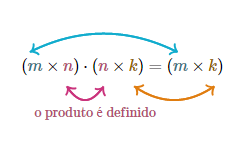

X(2000x2)*w(2x1) = y1(2000x1)

y =  y1(2000x1) + noise(2000x1) + b(constante=4.2) = vetor y(2000x1)

Parâmetros verdadeiros de w e b.

In [13]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
# w é vetor (2x1)
# b é constante

Mais tarde, podemos verificar nossos parâmetros estimados em relação a esses valores reais de w e b.

Vamos dar uma olhada na primeira entrada.

In [14]:
print('features:', data.X[0],'\nlabel:', data.y[0])
# X é matriz (2000x2)
# y é vetor 

features: tensor([-0.3416,  0.9991]) 
label: tensor([0.1097])


# 3.3.2. Lendo o conjunto de dados


O treinamento de modelos de aprendizado de máquina geralmente requer várias passagens por um conjunto de dados, capturando um minilote de exemplos por vez.

Cada minilote consiste em uma tupla de recursos e rótulos.

TUPLAS SÃO ATRIBUÍDAS COM PARÊNTESES (): ordenadas, IMUTÁVEIS e heterogêneas.

Observe que precisamos estar atentos se estamos no modo de treinamento ou de validação: no primeiro caso, desejaremos ler os dados em ordem aleatória, enquanto no segundo caso, ser capaz de ler os dados em uma ordem predefinida pode ser importante para fins de depuração.

In [16]:
# Captura minilotes

@d2l.add_to_class(SyntheticRegressionData)    # decorator para adicionar a função abaixo a classe SyntheticRegressionData, definida no bloco acima.
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]                  # bathc = lote

Para construir alguma intuição, vamos inspecionar o primeiro minilote de dados. Cada minilote de recursos nos fornece seu tamanho e a dimensionalidade dos recursos de entrada.

In [22]:
# tamanho e dimensão dos minilotes:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape) # formato correspondente ao dado por batch_size.

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [23]:
X


tensor([[ 4.8202e-01,  9.2355e-01],
        [-1.5656e+00,  7.8465e-01],
        [-9.5455e-01,  9.4418e-01],
        [ 1.7778e+00,  1.1652e+00],
        [-3.3992e-01, -1.2334e-01],
        [-5.0492e-01, -6.3566e-01],
        [ 1.5564e-03,  8.3945e-01],
        [ 2.4219e-01,  6.8536e-01],
        [ 1.5816e+00, -5.6994e-01],
        [ 4.6177e-01,  9.6429e-01],
        [ 1.6196e+00, -5.8640e-01],
        [-6.8853e-01, -9.2196e-01],
        [-5.1552e-01,  3.8848e-01],
        [-3.4202e-01,  1.2978e+00],
        [ 5.1484e-01, -7.0059e-03],
        [-1.7689e-01, -2.1734e+00],
        [-2.2064e-01,  6.6515e-01],
        [-9.7953e-01, -2.8153e-01],
        [-1.6813e+00,  1.3182e+00],
        [ 1.2544e+00,  1.4456e+00],
        [-6.2267e-02,  9.5363e-02],
        [ 1.6020e+00, -8.4862e-01],
        [ 7.9960e-01,  4.7855e-01],
        [ 7.8112e-01,  7.5517e-01],
        [ 1.3904e+00,  1.3744e+00],
        [-7.5878e-02,  1.7247e+00],
        [ 2.4189e-01, -5.6747e-01],
        [ 2.7691e-01, -3.841

# 3.3.3. Implementação concisa do carregador de dados 

Embora a iteração implementada acima seja boa para fins didáticos, ela é ineficiente de maneiras que podem nos causar problemas reais. 
Por exemplo, requer que carreguemos todos os dados na memória e realizemos muitos acessos aleatórios à memória. Os iteradores integrados implementados em uma estrutura de aprendizado profundo são consideravelmente mais eficientes e podem lidar com fontes como dados armazenados em arquivos, dados recebidos por meio de um fluxo e dados gerados ou processados ​​dinamicamente. A seguir, vamos tentar implementar o mesmo método usando iteradores integrados.


__Em vez de escrever nosso próprio iterador, podemos chamar a API existente em uma estrutura para carregar dados__. Como antes, precisamos de um conjunto de dados com recursos X e rótulos y. 

In [34]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)   # https://pytorch.org/docs/stable/data.html
    # return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train, drop_last = True)   # https://pytorch.org/docs/stable/data.html

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

drop_last (bool, optional) – set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

O novo carregador de dados se comporta exatamente como o anterior, exceto que é mais eficiente e possui algumas funcionalidades adicionais.

In [35]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


Por exemplo, o carregador de dados fornecido pela API do framework suporta o método integrado \__len\___, para que possamos consultar seu comprimento, ou seja, o número de lotes.

In [36]:
len(data.train_dataloader())

31

Os carregadores de dados são uma maneira conveniente de abstrair o processo de carregamento e manipulação de dados.

__Uma das coisas boas dos carregadores de dados é que eles podem ser compostos.__ Por exemplo, podemos carregar imagens e então ter um filtro de pós-processamento que as recorta ou modifica de outras maneiras. 



Quanto ao modelo em si, o modelo linear bidimensional é o mais simples que podemos encontrar. Permite-nos testar a precisão dos modelos de regressão sem nos preocuparmos com quantidades insuficientes de dados ou com um sistema de equações subdeterminado.

# Exercícios

In [2]:
# Ex. 1: What will happen if the number of examples cannot be divided by the batch size. 
# How would you change this behavior by specifying a different argument by using the framework’s API?

# Answered by GpuTooExpensive:

# I use ?torch.utils.data.DataLoader
# then find parameter “drop_last”,
# set it to true in the defination of function d2l.DataModule.get_tensorloader(), like:

@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train, drop_last = True)  # <---------------------------------
    
@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)
and test with

len(data.train_dataloader())
the result changed from 32 to 31

SyntaxError: invalid syntax (2568116255.py, line 21)

# Exercício 4:

In [43]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

x1 = torch.arange(40, dtype=torch.float32).reshape(20,2)
noise=0.01
noise1 = torch.randn(20, 1) * noise  # vetor noise (2000x1) com elementos aleatórios
 

class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""

    def __init__(self, w, b, noise=0.01, num_train=10, num_val=10, batch_size=5):            # batch=lotes de tamanho 32
        super().__init__()                  # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()
        n = num_train + num_val             # n = n_treinamento + n_validação = 1000 + 1000 = 2000
        # self.X = torch.randn(n, len(w))     # matriz X (2000x2) com elementos aleatórios
        # self.X = torch.arange(40, dtype=torch.float32).reshape(20,2)
        # self.X = torch.randn(20, 2)
        self.X = x1
        noise = noise1   # vetor noise (2000x1) com elementos aleatórios
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

# ------------------

data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
print('features:', data.X[0],'\nlabel:', data.y[0])


features: tensor([0., 1.]) 
label: tensor([0.8041])


In [44]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([0., 1.]) 
label: tensor([0.8041])
